# Setup

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import warnings
import csv
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
%load_ext autoreload
%aimport networks
from networks import BAGraph
%aimport log_bin
# helper functions
%aimport utils
font_size = 20
%autoreload 1

# Fixed m and varying N

In [145]:
from collections import Counter

folder = "data/ba/deg_dist"
powers_of_n = np.arange(2, 7)
N = 10**powers_of_n
m = 8
df = pd.DataFrame()
for n in N:
    print(n)
    # number of repeats
    data = []
    for i in range(1,41):
        folder_name = folder + str(i) + "/"
        filename = "{0}_{1}.txt".format(n, m)
        filepath = folder_name + filename
        with open(filepath, 'r') as f:
            reader = csv.reader(f)
            data_as_list = list(reader)
        x = data_as_list[0]
        x = [int(i) for i in x]
        data.append(x)
    counters = [Counter(x) for x in data]
    sums = dict(sum(counters, Counter()))
    data_mean = {x: float(sums[x]) / len(data) for x in sums.keys()}
    additional = pd.DataFrame.from_dict(data_mean, orient="index")
    additional.columns = [n]
    df = pd.concat([df, additional], axis=1)

100
1000
10000
100000
1000000


In [ ]:
degrees_df = df

for col in degrees_df:
    total = degrees_df[col].dropna().sum()
    degrees_df[col] = degrees_df[col] / total

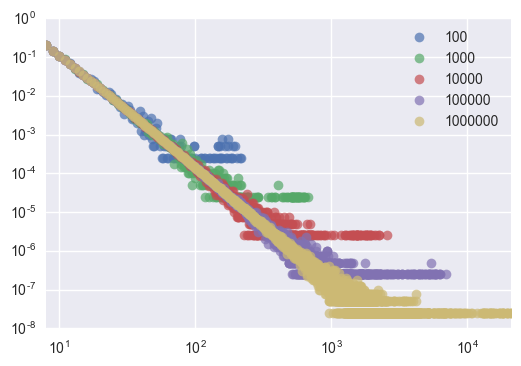

In [150]:
degrees_df.plot(loglog=True, style='o', alpha=0.7)

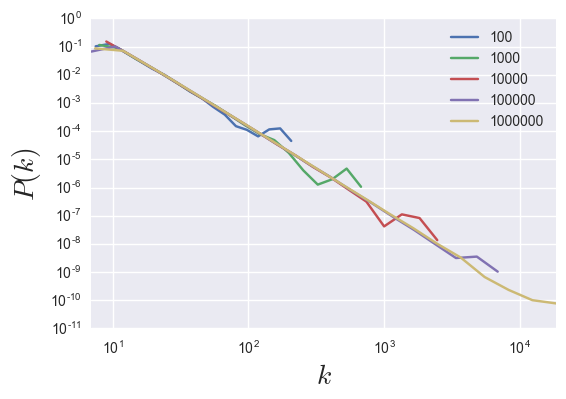

In [167]:
a = list(np.linspace(1.2, 1.5, len(log_binned_df.columns)))
log_binned_df = utils.log_bin_freq_and_plot(degrees_df, a=a, font_size=font_size, style='-', loglog=True)
plt.legend()

There is a dip then a bump, and they seem equally spaced on a loglog plot, implying a power law governing finite size scaling effects. 

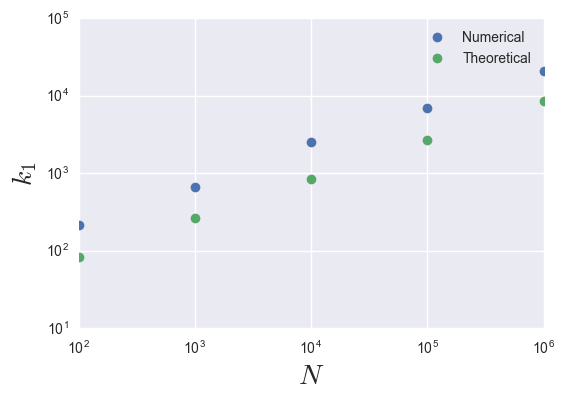

In [180]:
largest_expected_degree = []
largest_degree_theory = []
for col in degrees_df:
    a = degrees_df[col].dropna()[degrees_df[col] != 0].tail(1).index.values[0]
    k1 = utils.largest_degree(col, m)
    largest_expected_degree.append(a)
    largest_degree_theory.append(k1)
current_palette = sns.color_palette()
pd.Series(largest_expected_degree, index=degrees_df.columns).plot(style='o', loglog=True, label='Numerical')
pd.Series(largest_degree_theory, index=degrees_df.columns).plot(marker='o', linestyle='None', color=current_palette[1],
                                                                loglog=True, label='Theoretical')
ax = plt.gca()
plt.legend()
ax.set_ylabel(u"$k_1$", fontsize=font_size)
ax.set_xlabel(u"$N$", fontsize=font_size)

Numerical result is offset from the theoretical result by a constant value. 

# Fixed N and varying m

In [3]:
folder = "data/ba/deg_dist/"
import csv
n = 10**7
# M = [4]
M = [1, 2, 4, 8, 16, 32]
total = []
df = pd.DataFrame()
for m in M:
    filename = "{0}_{1}.txt".format(n, m)
    filepath = folder + filename
    print(filepath)
    
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        data_as_list = list(reader)
    x = data_as_list[0]
    x = [int(i) for i in x]
    df[m] = x

data/ba/deg_dist/10000000_1.txt
data/ba/deg_dist/10000000_2.txt
data/ba/deg_dist/10000000_4.txt
data/ba/deg_dist/10000000_8.txt
data/ba/deg_dist/10000000_16.txt
data/ba/deg_dist/10000000_32.txt


In [4]:
fixed_n_df = df

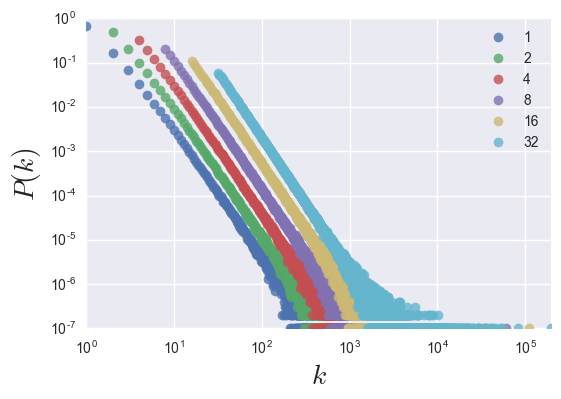

In [5]:
fixed_n_degrees = utils.value_counts_and_plot(fixed_n_df)
ax = plt.gca()
ax.set_ylabel(u'$P(k)$', fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)

## Visualizing ccdf

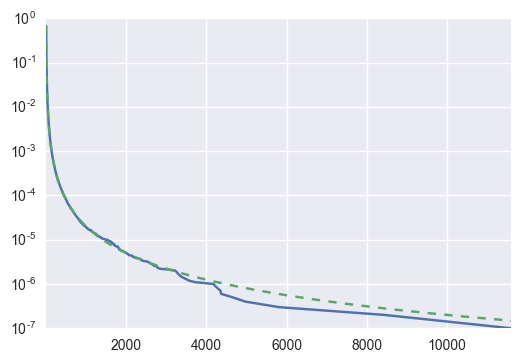

In [101]:
utils.visualize_ccdf(fixed_n_degrees, 4)

## log bin

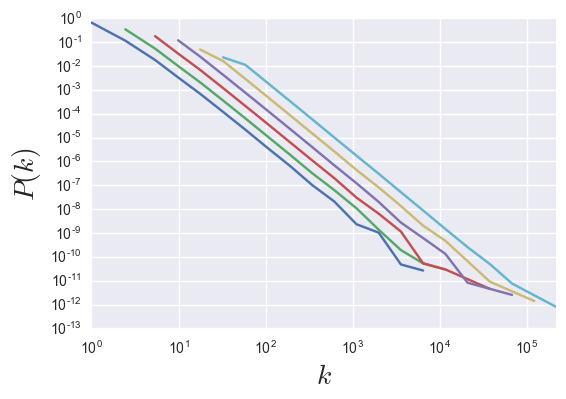

In [102]:
fixed_n_logbin = utils.log_bin_and_plot(fixed_n_df, a=1.8, font_size=font_size, style='-', loglog=True)

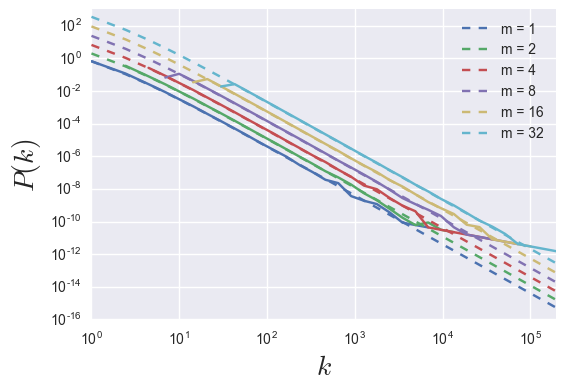

In [8]:
# plot numerical results
utils.log_bin_and_plot(fixed_n_df, a=1.4, font_size=font_size, style='-', loglog=True, label='__nolegend__')
result = utils.get_model_df(fixed_n_logbin, fixed_n_logbin.columns)

# plot model
current_palette = sns.color_palette()
for i, col in enumerate(result):
    result[col].dropna().plot(loglog=True, style='--', color=current_palette[i], label='m = '+str(col))
plt.legend()

## ks test

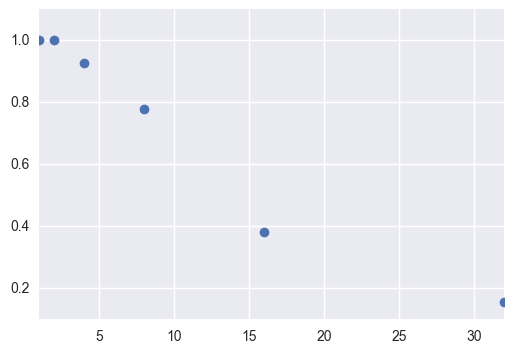

In [15]:
pvalues = []
for col in fixed_n_logbin:
    model_values = utils.deg_dist_theory(col, fixed_n_logbin[col].dropna().index)
    ks_stat, pvalue = scipy.stats.ks_2samp(fixed_n_logbin[col].dropna().values, model_values)
    pvalues.append(pvalue)
pd.Series(pvalues, index=fixed_n_logbin.columns).plot(style='o')

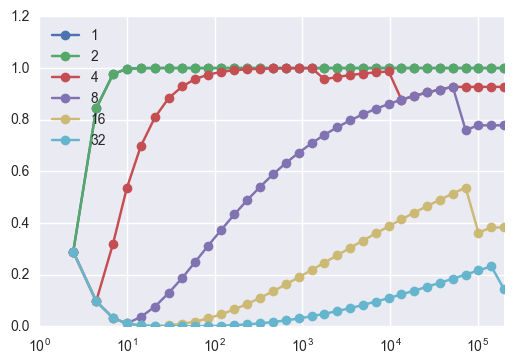

In [10]:
ks_pvalues = pd.DataFrame()
for col in fixed_n_logbin:
    model_values = utils.deg_dist_theory(col, fixed_n_logbin[col].dropna().index)
    col_list = []
    for i, value in enumerate(fixed_n_logbin[col]):
        if value == np.nan or i == 0:
            col_list.append(np.nan)
            continue
        ks_stat, pvalue = scipy.stats.ks_2samp(fixed_n_logbin[col].head(i).dropna().values, model_values[:i])
        col_list.append(pvalue)
    additional = pd.DataFrame({col: col_list}, index=fixed_n_logbin[col].index)
    ks_pvalues = pd.concat([ks_pvalues, additional], axis=1)
ks_pvalues.plot(style='-o', logx=True)

## Pearson coefficient

In [11]:
model_df = utils.get_model_df(fixed_n_logbin, fixed_n_logbin.columns)
# model_df.corrwith(fixed_n_logbin)
from IPython.display import display
for col in fixed_n_logbin:
    new_df = pd.DataFrame({'numerical': fixed_n_logbin[col], 'theory': model_df[col]}, index=fixed_n_logbin.index)
    new_df = new_df.dropna()
    print(col)
    display(new_df.corr())

1


,numerical,theory
numerical,1.000000,0.999887
theory,0.999887,1.000000


2


,numerical,theory
numerical,1.000000,0.108751
theory,0.108751,1.000000


4


,numerical,theory
numerical,1.000000,-0.020779
theory,-0.020779,1.000000


8


,numerical,theory
numerical,1.000000,-0.062749
theory,-0.062749,1.000000


16


,numerical,theory
numerical,1.000000,-0.069706
theory,-0.069706,1.000000


32


,numerical,theory
numerical,1.000000,-0.066998
theory,-0.066998,1.000000
